In [1]:
# trying out tunfold

In [3]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
print("awkward version ", ak.__version__)
print("coffea version ", coffea.__version__)
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt
import boost_histogram as bh
from smp_utils import *

awkward version  1.10.3
coffea version  0.7.21


In [3]:
constants = util_constants()

In [21]:
%matplotlib widget

In [4]:
with open("qjetmass_zjets_gen_backup.pkl", "rb") as f:
    output_gen = pickle.load( f )

In [5]:
output_gen.keys()

dict_keys(['njet_gen', 'njet_reco', 'ptjet_gen_pre', 'ptjet_mjet_u_gen', 'ptjet_mjet_u_reco', 'ptjet_mjet_g_gen', 'ptjet_mjet_g_reco', 'ptjet_reco_over_gen', 'drjet_reco_gen', 'ptz_gen', 'ptz_reco', 'mz_gen', 'mz_reco', 'mz_reco_over_gen', 'dr_z_jet_gen', 'dr_z_jet_reco', 'dphi_z_jet_gen', 'dphi_z_jet_reco', 'ptasym_z_jet_gen', 'ptasym_z_jet_reco', 'ptfrac_z_jet_gen', 'ptfrac_z_jet_reco', 'm_u_jet_reco_over_gen', 'm_g_jet_reco_over_gen', 'dr_gen_subjet', 'dr_reco_to_gen_subjet', 'response_matrix_u', 'response_matrix_g', 'cutflow'])

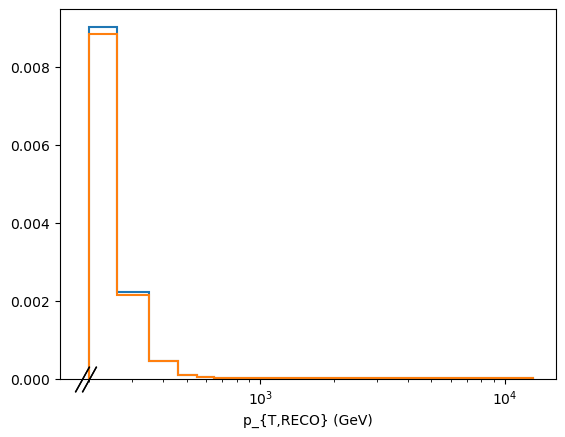

In [6]:
output_gen["response_matrix_u"].project("ptreco").plot(density = True)
output_gen["response_matrix_u"].project("ptgen").plot(density = True)
plt.xscale('log')

In [7]:
output_gen["response_matrix_u"]

Hist(
  StrCategory(['UL16NanoAODv9', 'UL18NanoAODv9', 'UL17NanoAODv9'], growth=True, name='dataset', label='Primary dataset'),
  Variable([200, 260, 350, 460, 550, 650, 760, 13000], name='ptreco', label='p_{T,RECO} (GeV)'),
  Variable([0, 5, 10, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 1000], name='mreco', label='m_{RECO} (GeV)'),
  Variable([200, 260, 350, 460, 550, 650, 760, 13000], name='ptgen', label='p_{T,RECO} (GeV)'),
  Variable(array([   0. ,    2.5,    5. ,    7.5,   10. ,   15. ,   20. ,   30. ,
         40. ,   50. ,   60. ,   70. ,   80. ,   90. ,  100. ,  125. ,
        150. ,  175. ,  200. ,  225. ,  250. ,  275. ,  300. ,  325. ,
        350. , 1000. ]), name='mgen', label='Mass [GeV]'),
  StrCategory(['pu_nominal', 'pu_U', 'pu_D'], growth=True, name='systematic', label='Systematic Uncertainty'),
  storage=Weight()) # Sum: WeightedSum(value=76705.6, variance=3336.54) (WeightedSum(value=229510, variance=19691.8) with flow)

In [8]:
import matplotlib.pyplot as plt

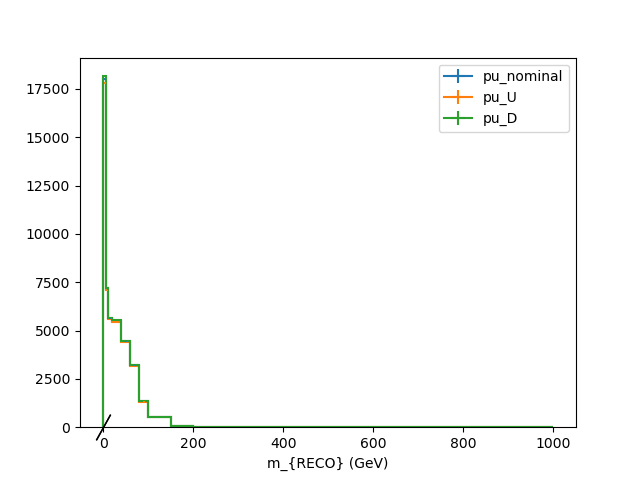

In [22]:
fig = plt.figure()
#plt.xscale('log')
output_gen["response_matrix_g"].project("systematic", "mreco").plot()
plt.legend()

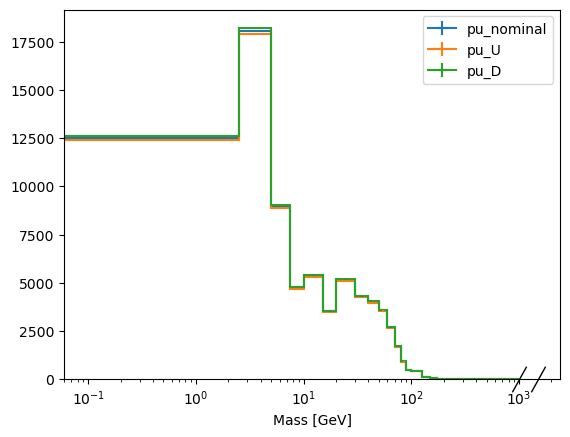

In [18]:
fig = plt.figure()
plt.xscale('log')
output_gen["response_matrix_g"].project("systematic", "mgen").plot()
plt.legend()

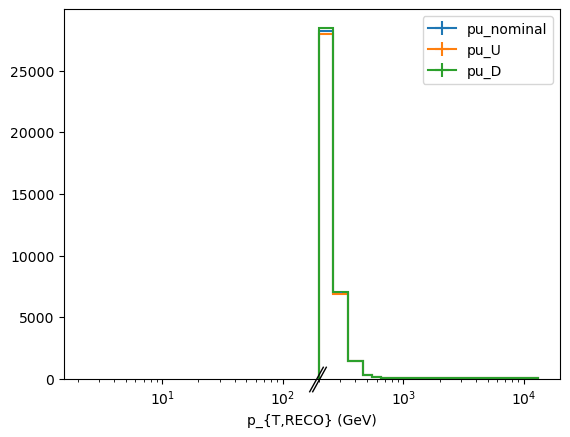

In [16]:
fig = plt.figure()
plt.xscale('log')
output_gen["response_matrix_g"].project("systematic", "ptreco").plot()
plt.legend()

In [4]:
fname = 'root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL18NanoAODv9/DYJetsToLL_M-50_HT-1200to2500_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/120000/26793660-5D04-C24B-813E-3C1744C84D2D.root'

events = NanoEventsFactory.from_root(
    fname,
    schemaclass=NanoAODSchema.v6,
    metadata={"dataset": "DYJets"},
).events()

In [11]:
from cms_utils import *
import os
GetJetCorrections(events.FatJet, events, era = None, IOV = '2018', isData = False)

Making evaluator


KeyError: 'pt_gen'

In [7]:
from coffea.lookup_tools import extractor
from coffea.jetmet_tools import JECStack, CorrectedJetsFactory, CorrectedMETFactory


def ApplyJetCorrections(isMC, IOV, era=None, corr_type=None, do_factorized_jec_unc=False):
    jer_tag=None
    if (IOV=='2018'):
        jec_tag="Summer19UL18_V5_MC"
        jec_tag_data={
            "RunA": "Summer19UL18_RunA_V5_DATA",
            "RunB": "Summer19UL18_RunB_V5_DATA",
            "RunC": "Summer19UL18_RunC_V5_DATA",
            "RunD": "Summer19UL18_RunD_V5_DATA",
        }
        jer_tag = "Summer19UL18_JRV2_MC"
    elif (IOV=='2017'):
        jec_tag="Summer19UL17_V5_MC"
        jec_tag_data={
            "RunB": "Summer19UL17_RunB_V5_DATA",
            "RunC": "Summer19UL17_RunC_V5_DATA",
            "RunD": "Summer19UL17_RunD_V5_DATA",
            "RunE": "Summer19UL17_RunE_V5_DATA",
            "RunF": "Summer19UL17_RunF_V5_DATA",
        }
        jer_tag = "Summer19UL17_JRV2_MC"
    elif (IOV=='2016'):
        jec_tag="Summer19UL16_V7_MC"
        jec_tag_data={
            "RunF": "Summer19UL16_RunFGH_V7_DATA",
            "RunG": "Summer19UL16_RunFGH_V7_DATA",
            "RunH": "Summer19UL16_RunFGH_V7_DATA",
        }
        jer_tag = "Summer20UL16_JRV3_MC"
    elif (IOV=='2016APV'):
        jec_tag="Summer19UL16APV_V7_MC"
        ## HIPM/APV     : B_ver1, B_ver2, C, D, E, F
        ## non HIPM/APV : F, G, H
        jec_tag_data={
            "RunB-ver1": "Summer19UL16APV_RunBCD_V7_DATA",
            "RunB-ver2": "Summer19UL16APV_RunBCD_V7_DATA",
            "RunC": "Summer19UL16APV_RunBCD_V7_DATA",
            "RunD": "Summer19UL16APV_RunBCD_V7_DATA",
            "RunE": "Summer19UL16APV_RunEF_V7_DATA",
            "RunF": "Summer19UL16APV_RunEF_V7_DATA",
        }
        jer_tag = "Summer20UL16APV_JRV3_MC"
    else:
        raise ValueError(f"Error: Unknown year \"{IOV}\".")
    
    extract = extractor()
    if (isMC):
        #For MC
        extract.add_weight_sets([
            '* * data/JEC/{0}/{0}_L1FastJet_AK4PFchs.txt'.format(jec_tag),
            '* * data/JEC/{0}/{0}_L2Relative_AK4PFchs.txt'.format(jec_tag),
            '* * data/JEC/{0}/{0}_L3Absolute_AK4PFchs.txt'.format(jec_tag),
            '* * data/JEC/{0}/{0}_UncertaintySources_AK4PFchs.junc.txt'.format(jec_tag),
            '* * data/JEC/{0}/{0}_Uncertainty_AK4PFchs.junc.txt'.format(jec_tag),
        ])

        if jer_tag:
            extract.add_weight_sets([
            '* * data/JER/{0}/{0}_PtResolution_AK4PFchs.jr.txt'.format(jer_tag),
            '* * data/JER/{0}/{0}_SF_AK4PFchs.jersf.txt'.format(jer_tag)])
    else:       
        #For data, make sure we don't duplicate
        tags_done = []
        for run, tag in jec_tag_data.items():
            if not (tag in tags_done):
                extract.add_weight_sets([
                '* * data/JEC/{0}/{0}_L1FastJet_AK4PFchs.txt'.format(tag),
                '* * data/JEC/{0}/{0}_L2Relative_AK4PFchs.txt'.format(tag),
                '* * data/JEC/{0}/{0}_L3Absolute_AK4PFchs.txt'.format(tag),
                '* * data/JEC/{0}/{0}_L2L3Residual_AK4PFchs.txt'.format(tag),
                ])
                tags_done += [tag]
                
    extract.finalize()
    evaluator = extract.make_evaluator()
    
    if (isMC):
        jec_names = [
            '{0}_L1FastJet_AK4PFchs'.format(jec_tag),
            '{0}_L2Relative_AK4PFchs'.format(jec_tag),
            '{0}_L3Absolute_AK4PFchs'.format(jec_tag),
            '{0}_Uncertainty_AK4PFchs'.format(jec_tag)]
        if do_factorized_jec_unc:
            for name in dir(evaluator):
               #factorized sources
               if '{0}_UncertaintySources_AK4PFchs'.format(jec_tag) in name:
                    jec_names.append(name)
        if jer_tag: 
            jec_names.extend(['{0}_PtResolution_AK4PFchs'.format(jer_tag),
                              '{0}_SF_AK4PFchs'.format(jer_tag)])

    else:
        jec_names={}
        for run, tag in jec_tag_data.items():
            jec_names[run] = [
                '{0}_L1FastJet_AK4PFchs'.format(tag),
                '{0}_L3Absolute_AK4PFchs'.format(tag),
                '{0}_L2Relative_AK4PFchs'.format(tag),
                '{0}_L2L3Residual_AK4PFchs'.format(tag),]
    if isMC:
        jec_inputs = {name: evaluator[name] for name in jec_names}
    else:
        jec_inputs = {name: evaluator[name] for name in jec_names[era]}
    
    jec_stack = JECStack(jec_inputs)
    name_map = jec_stack.blank_name_map
    name_map['JetPt'] = 'pt'
    name_map['JetEta'] = 'eta'
    name_map['JetPhi'] = 'phi'
    name_map['JetMass'] = 'mass'
    name_map['Rho'] = 'rho'
    name_map['JetA'] = 'area'
    name_map['ptGenJet'] = 'pt_gen'
    name_map['ptRaw'] = 'pt_raw'
    name_map['massRaw'] = 'mass_raw'
    name_map['METpt'] = 'pt'
    name_map['METphi'] = 'phi'
    name_map['UnClusteredEnergyDeltaX'] = 'MetUnclustEnUpDeltaX'
    name_map['UnClusteredEnergyDeltaY'] = 'MetUnclustEnUpDeltaY'
    if corr_type=='met': return CorrectedMETFactory(name_map)
    return CorrectedJetsFactory(name_map, jec_stack)


In [9]:
a = ApplyJetCorrections(isMC = True, IOV = "2018", era=None, corr_type=None, do_factorized_jec_unc=False)

FileNotFoundError: [Errno 2] No such file or directory: 'data/JEC/Summer19UL18_V5_MC/Summer19UL18_V5_MC_L1FastJet_AK4PFchs.txt'

In [7]:
import time
from coffea import nanoevents, util
import hist
import coffea.processor as processor
import awkward as ak
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import glob as glob
import re
import itertools
import vector as vec
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoAODSchema
from coffea.lumi_tools import LumiMask
# for applying JECs
from coffea.lookup_tools import extractor
from coffea.jetmet_tools import JECStack, CorrectedJetsFactory
#from jmeCorrections import ApplyJetCorrections, corrected_polar_met
from collections import defaultdict
import correctionlib
import os

def GetJetCorrections(FatJets, events, era, IOV, isData=False):
    #### I haven't had any issues where i need an "upload directory" like here
    # uploadDir = 'srv/' for lpcjobqueue shell or TTbarAllHadUproot/ for coffea casa
    # uploadDir = os.getcwd().replace('/','') + '/'
    # if 'TTbarAllHadUproot' in uploadDir: 
    #     uploadDir = 'TTbarAllHadUproot/'
    # elif 'jovyan' in uploadDir:
    #     uploadDir = 'TTbarAllHadUproot/'
    # else:
    #     uploadDir = 'srv/'

    # original code https://gitlab.cern.ch/gagarwal/ttbardileptonic/-/blob/master/jmeCorrections.py
    jer_tag=None
    if (IOV=='2018'):
        jec_tag="Summer19UL18_V5_MC"
        jec_tag_data={
            "Run2018A": "Summer19UL18_RunA_V5_DATA",
            "Run2018B": "Summer19UL18_RunB_V5_DATA",
            "Run2018C": "Summer19UL18_RunC_V5_DATA",
            "Run2018D": "Summer19UL18_RunD_V5_DATA",
        }
        jer_tag = "Summer19UL18_JRV2_MC"
    elif (IOV=='2017'):
        jec_tag="Summer19UL17_V5_MC"
        jec_tag_data={
            "Run2017B": "Summer19UL17_RunB_V5_DATA",
            "Run2017C": "Summer19UL17_RunC_V5_DATA",
            "Run2017D": "Summer19UL17_RunD_V5_DATA",
            "Run2017E": "Summer19UL17_RunE_V5_DATA",
            "Run2017F": "Summer19UL17_RunF_V5_DATA",
        }
        jer_tag = "Summer19UL17_JRV3_MC"
    elif (IOV=='2016'):
        jec_tag="Summer19UL16_V7_MC"
        jec_tag_data={
            "Run2016F": "Summer19UL16_RunFGH_V7_DATA",
            "Run2016G": "Summer19UL16_RunFGH_V7_DATA",
            "Run2016H": "Summer19UL16_RunFGH_V7_DATA",
        }
        jer_tag = "Summer20UL16_JRV3_MC"
    elif (IOV=='2016APV'):
        jec_tag="Summer19UL16_V7_MC"
        ## HIPM/APV     : B_ver1, B_ver2, C, D, E, F
        ## non HIPM/APV : F, G, H

        jec_tag_data={
            "Run2016B": "Summer19UL16APV_RunBCD_V7_DATA",
            "Run2016C": "Summer19UL16APV_RunBCD_V7_DATA",
            "Run2016D": "Summer19UL16APV_RunBCD_V7_DATA",
            "Run2016E": "Summer19UL16APV_RunEF_V7_DATA",
            "Run2016F": "Summer19UL16APV_RunEF_V7_DATA",
        }
        jer_tag = "Summer20UL16APV_JRV3_MC"
    else:
        print(f"Error: Unknown year \"{IOV}\".")


    #print("extracting corrections from files for " + jec_tag)
    ext = extractor()
    if not isData:
    #For MC
        ext.add_weight_sets([
            '* * '+'correctionFiles/JEC/{0}/{0}_L1FastJet_AK8PFPuppi.jec.txt'.format(jec_tag),
            '* * '+'correctionFiles/JEC/{0}/{0}_L2Relative_AK8PFPuppi.jec.txt'.format(jec_tag),
            '* * '+'correctionFiles/JEC/{0}/{0}_L3Absolute_AK8PFPuppi.jec.txt'.format(jec_tag),
            '* * '+'correctionFiles/JEC/{0}/{0}_UncertaintySources_AK8PFPuppi.junc.txt'.format(jec_tag),
            '* * '+'correctionFiles/JEC/{0}/{0}_Uncertainty_AK8PFPuppi.junc.txt'.format(jec_tag),
        ])
        #### Do AK8PUPPI jer files exist??
        if jer_tag:
            print("JER tag: ", jer_tag)
            print("File "+'correctionFiles/JER/{0}/{0}_PtResolution_AK8PFPuppi.jr.txt'.format(jer_tag)+" exists: ", os.path.exists('correctionFiles/JER/{0}/{0}_PtResolution_AK8PFPuppi.jr.txt'.format(jer_tag)))
            print("File "+'correctionFiles/JER/{0}/{0}_SF_AK8PFPuppi.jersf.txt'.format(jer_tag)+" exists: ", os.path.exists('correctionFiles/JER/{0}/{0}_SF_AK8PFPuppi.jersf.txt'.format(jer_tag)))
            ext.add_weight_sets([
            '* * '+'correctionFiles/JER/{0}/{0}_PtResolution_AK8PFPuppi.jr.txt'.format(jer_tag),
            '* * '+'correctionFiles/JER/{0}/{0}_SF_AK8PFPuppi.jersf.txt'.format(jer_tag)])
            print("JER SF added")
    else:       
        #For data, make sure we don't duplicat
        tags_done = []
        for run, tag in jec_tag_data.items():
            if not (tag in tags_done):
                ext.add_weight_sets([
                '* * '+'correctionFiles/JEC/{0}/{0}_L1FastJet_AK8PFPuppi.jec.txt'.format(tag),
                '* * '+'correctionFiles/JEC/{0}/{0}_L2Relative_AK8PFPuppi.jec.txt'.format(tag),
                '* * '+'correctionFiles/JEC/{0}/{0}_L3Absolute_AK8PFPuppi.jec.txt'.format(tag),
                '* * '+'correctionFiles/JEC/{0}/{0}_L2L3Residual_AK8PFPuppi.jec.txt'.format(tag),
                ])
                tags_done += [tag]
    ext.finalize()

    print("Making evaluator")

    evaluator = ext.make_evaluator()



    if (not isData):
        jec_names = [
            '{0}_L1FastJet_AK8PFPuppi'.format(jec_tag),
            '{0}_L2Relative_AK8PFPuppi'.format(jec_tag),
            '{0}_L3Absolute_AK8PFPuppi'.format(jec_tag),
            '{0}_Uncertainty_AK8PFPuppi'.format(jec_tag)]

        if jer_tag: 
            jec_names.extend(['{0}_PtResolution_AK8PFPuppi'.format(jer_tag),
                              '{0}_SF_AK8PFPuppi'.format(jer_tag)])

    else:
        jec_names={}
        for run, tag in jec_tag_data.items():
            jec_names[run] = [
                '{0}_L1FastJet_AK8PFPuppi'.format(tag),
                '{0}_L3Absolute_AK8PFPuppi'.format(tag),
                '{0}_L2Relative_AK8PFPuppi'.format(tag),
                '{0}_L2L3Residual_AK8PFPuppi'.format(tag),]



    if not isData:
        jec_inputs = {name: evaluator[name] for name in jec_names}
    else:
        jec_inputs = {name: evaluator[name] for name in jec_names[era]}



    jec_stack = JECStack(jec_inputs)


    FatJets['pt_raw'] = (1 - FatJets['rawFactor']) * FatJets['pt']
    FatJets['mass_raw'] = (1 - FatJets['rawFactor']) * FatJets['mass']
    FatJets['rho'] = ak.broadcast_arrays(events.fixedGridRhoFastjetAll, FatJets.pt)[0]
    FatJets['pt_gen'] = ak.values_astype(ak.fill_none(FatJets.matched_gen.pt, 0), np.float32)
    
    name_map = jec_stack.blank_name_map
    name_map['JetPt'] = 'pt'
    name_map['JetMass'] = 'mass'
    name_map['JetEta'] = 'eta'
    name_map['JetA'] = 'area'
    name_map['ptGenJet'] = 'pt_gen'
    name_map['ptRaw'] = 'pt_raw'
    name_map['massRaw'] = 'mass_raw'
    name_map['Rho'] = 'rho'


    events_cache = events.caches[0]

    jet_factory = CorrectedJetsFactory(name_map, jec_stack)
    corrected_jets = jet_factory.build(FatJets, lazy_cache=events_cache)
    print("Built corrections object")
    return corrected_jets

In [8]:
GetJetCorrections(events.FatJet, events, era = None, IOV = '2018', isData = False)

JER tag:  Summer19UL18_JRV2_MC
File correctionFiles/JER/Summer19UL18_JRV2_MC/Summer19UL18_JRV2_MC_PtResolution_AK8PFPuppi.jr.txt exists:  True
File correctionFiles/JER/Summer19UL18_JRV2_MC/Summer19UL18_JRV2_MC_SF_AK8PFPuppi.jersf.txt exists:  True
JER SF added
Making evaluator


AttributeError: no field named 'genJetAK8IdxG'

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/awkward/highlevel.py#L1124)

In [11]:
events.FatJet.matched_gen.pt

AttributeError: no field named 'genJetAK8IdxG'

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/awkward/highlevel.py#L1124)

In [18]:
events.FatJet.matched_gen.pt

AttributeError: no field named 'genJetAK8IdxG'

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/awkward/highlevel.py#L1124)

In [17]:
events.FatJet.pt

<Array [[723, 662, 240, ... 586, 442, 198]] type='580658 * var * float32[paramet...'>

In [19]:
events.fields

['GenVtx',
 'ChsMET',
 'Flag',
 'CorrT1METJet',
 'DeepMETResponseTune',
 'Photon',
 'event',
 'LHEPart',
 'GenVisTau',
 'SoftActivityJetNjets10',
 'PV',
 'LHE',
 'fixedGridRhoFastjetCentralNeutral',
 'TrigObj',
 'GenDressedLepton',
 'GenPart',
 'IsoTrack',
 'PuppiMET',
 'RawPuppiMET',
 'GenIsolatedPhoton',
 'GenJetAK8',
 'LHEReweightingWeight',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'L1PreFiringWeight',
 'genTtbarId',
 'SoftActivityJetHT2',
 'SoftActivityJetHT5',
 'SubJet',
 'btagWeight',
 'SoftActivityJetNjets2',
 'fixedGridRhoFastjetCentral',
 'SoftActivityJet',
 'GenJet',
 'LHEPdfWeight',
 'Electron',
 'LHEScaleWeight',
 'CaloMET',
 'HLTriggerFirstPath',
 'FsrPhoton',
 'LowPtElectron',
 'fixedGridRhoFastjetCentralCalo',
 'Generator',
 'Jet',
 'MET',
 'SoftActivityJetHT10',
 'HLTriggerFinalPath',
 'genWeight',
 'fixedGridRhoFastjetAll',
 'run',
 'OtherPV',
 'SoftActivityJetNjets5',
 'SV',
 'L1Reco',
 'boostedTau',
 'SoftActivityJetHT',
 'PSWeight',
 'Tau',
 'DeepMETResolutionTu